In [120]:
import sounddevice as sd
import numpy as np
import scipy
import soundfile as sf
import matplotlib
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.signal import hamming,stft, spectrogram,hann 
import librosa
from librosa import display as dp
from IPython.display import Audio

In [121]:
def lib_pow_spect(data,win_length=500,hop_length=100):
    dfts=librosa.stft(data,window=hamming,n_fft=2*win_length,hop_length=hop_length)
    return dfts

In [130]:
def sep_percusion_harmony(win_length,hop_length,F,pow_spect,Fs,gamma,alpha):
    k_max=60
#     sigma_p=0.5
#     sigma_h=0.5
    W=abs(F)**(2*gamma)
    H=W/2
    P=W/2
    for k in range(k_max):
            term_1 = np.zeros_like(H)
            term_2 = np.zeros_like(P)
            for i_iter in range(1, np.shape(H)[1]-1):
                term_1[:, i_iter] = alpha * ((H[:, i_iter-1] - (2 * H[:, i_iter])+ H[:, i_iter+1] ) / 4)

            for h_iter in range(1, np.shape(H)[0]-1):
                term_2[h_iter, :] = (1 - alpha) * ((P[h_iter-1, :] + P[h_iter+1, :] - (2 * P[h_iter, :])) / 4)
                
            #As the 0th and Nth component will not have previous or next row/column
            term_1[:, 0] = alpha * ((H[:, 1] - H[:, 0]) / 2)
            term_1[:, -1] = alpha * ((H[:, -2] - H[:, -1]) / 2)
            
            term_2[0, :] = (1 - alpha) * ((P[1, :] - P[0, :]) / 2)
            term_2[-1, :] = (1 - alpha) * ((P[-2, :] - P[-1, :]) / 2)

            delta = term_1 - term_2
            H = np.minimum(np.maximum(H + delta, 0), W)
            P = W - H
    
    #binarizing the components 
    H_ = np.where(np.less(H, P), 0, W)
    P_ = np.where(np.greater_equal(H, P),0,W)
    H=H_
    p=P_

    #ISTFT
    H_temp = np.power(H, (1 / (2 * gamma))) * np.exp(1j * np.angle(F)) 
    P_temp = np.power(P, (1 / (2 * gamma))) * np.exp(1j * np.angle(F)) 
    h = librosa.istft(H_temp, window='hann',hop_length=hop_length , win_length=win_length, center=True, dtype=None, length=None)
    p = librosa.istft(P_temp, window='hann',hop_length=hop_length , win_length=win_length, center=True, dtype=None, length=None)
    return h,p,H,P

<ipython-input-160-6b3de5748be7>:26: RuntimeWarning: divide by zero encountered in log10
  dp.specshow(20*np.log10(H), y_axis='linear',ax=axes[3])
<ipython-input-160-6b3de5748be7>:31: RuntimeWarning: divide by zero encountered in log10
  dp.specshow(20*np.log10(P), y_axis='linear',ax=axes[5])#,cmap='gist_earth')


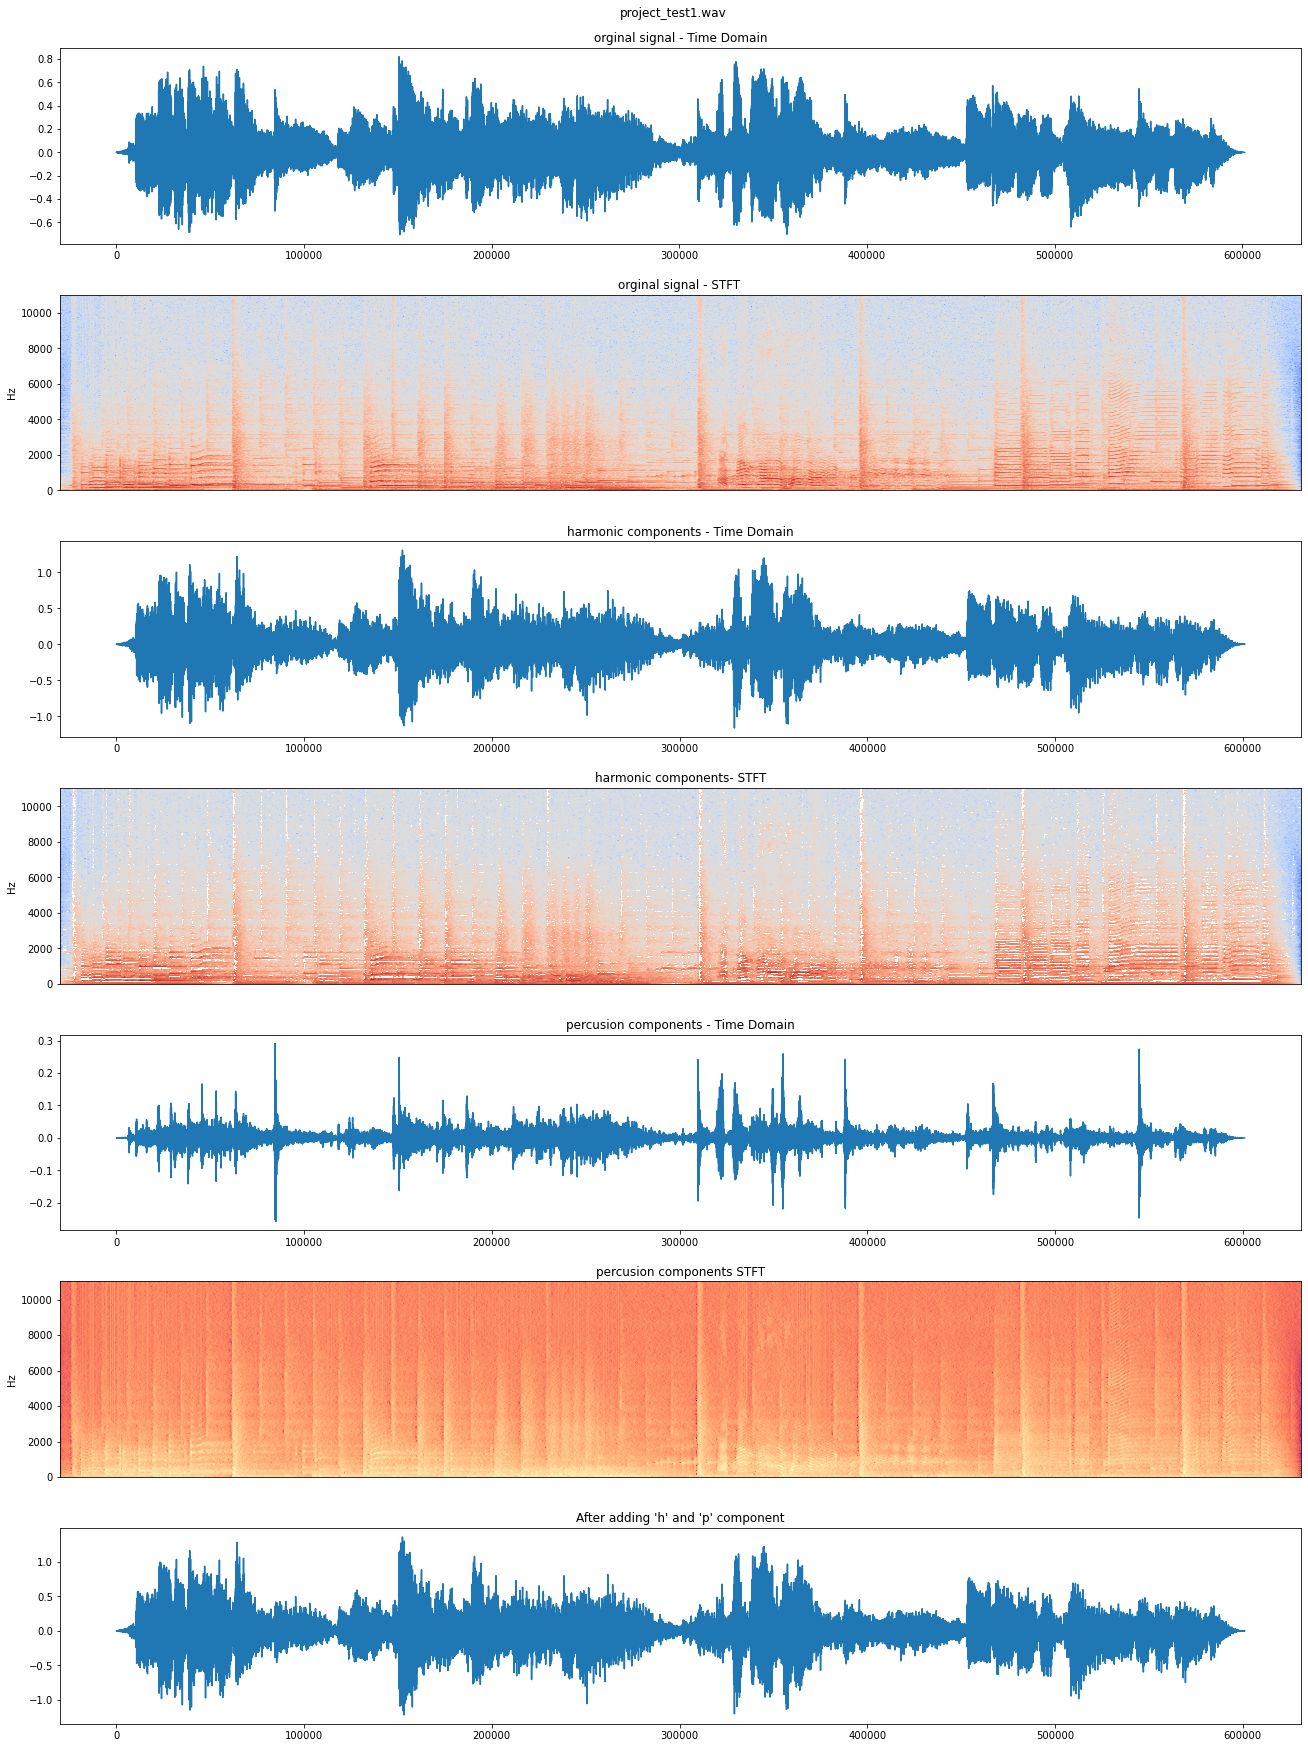

In [160]:
'''
for signal - project_test1
'''
data, Fs = sf.read('project_test1.wav')
gamma=0.2
alpha=0.3
#sd.play(data,Fs)
win_length=int(0.02*Fs)
hop_length=int(0.01*Fs)
F=lib_pow_spect(data,win_length,hop_length)
W=np.abs(F)**2
h,p,H,P=sep_percusion_harmony(win_length,hop_length,F,W,Fs,gamma,alpha)


fig,axes=plt.subplots(7,figsize=(25,15))
fig.suptitle("project_test1.wav")
fig.set_size_inches(18.5, 25)
fig.tight_layout(pad=3.0)
axes[0].plot(data)
axes[0].set_title("orginal signal - Time Domain")
dp.specshow(20*np.log10(W), y_axis='linear',ax=axes[1])
axes[1].set_title("orginal signal - STFT ")

axes[2].plot(h)
axes[2].set_title("harmonic components - Time Domain")
dp.specshow(20*np.log10(H), y_axis='linear',ax=axes[3])
axes[3].set_title("harmonic components- STFT")

axes[4].plot(p)
axes[4].set_title("percusion components - Time Domain")
dp.specshow(20*np.log10(P), y_axis='linear',ax=axes[5])#,cmap='gist_earth')
axes[5].set_title("percusion components STFT")

axes[6].plot(h+p)
axes[6].set_title("After adding 'h' and 'p' component")
plt.show()



In [153]:
#percusion of the project_test1
sd.play(p,Fs)

In [154]:
#harmonic of the project_test1
sd.play(h,Fs)

In [155]:
#SNR for project_test1.wav

short_size= data.size if data.size<h.size else h.size
temp_signal=h+p
noise_ratio=20*np.log10(np.sum(np.power(data,2))/np.sum(np.power(data[:short_size]- temp_signal[:short_size],2)))
print("the signal to noise ratio is "+str(noise_ratio))
print("the hyper parameters are ")
print("gamma "+str(gamma))
print("alpha "+str(alpha))
print("the value for the hyper parameters are found through trial and error method")

the signal to noise ratio is 14.985863805119486
the hyper parameters are 
gamma 0.1
alpha 0.3
the value for the hyper parameters are found through trial and error method


<ipython-input-156-bb65502a1e9e>:22: RuntimeWarning: divide by zero encountered in log10
  dp.specshow(20*np.log10(W), y_axis='linear',ax=axes[1])
<ipython-input-156-bb65502a1e9e>:27: RuntimeWarning: divide by zero encountered in log10
  dp.specshow(20*np.log10(H), y_axis='linear',ax=axes[3])
<ipython-input-156-bb65502a1e9e>:32: RuntimeWarning: divide by zero encountered in log10
  dp.specshow(20*np.log10(P), y_axis='linear',ax=axes[5])#,cmap='gist_earth')


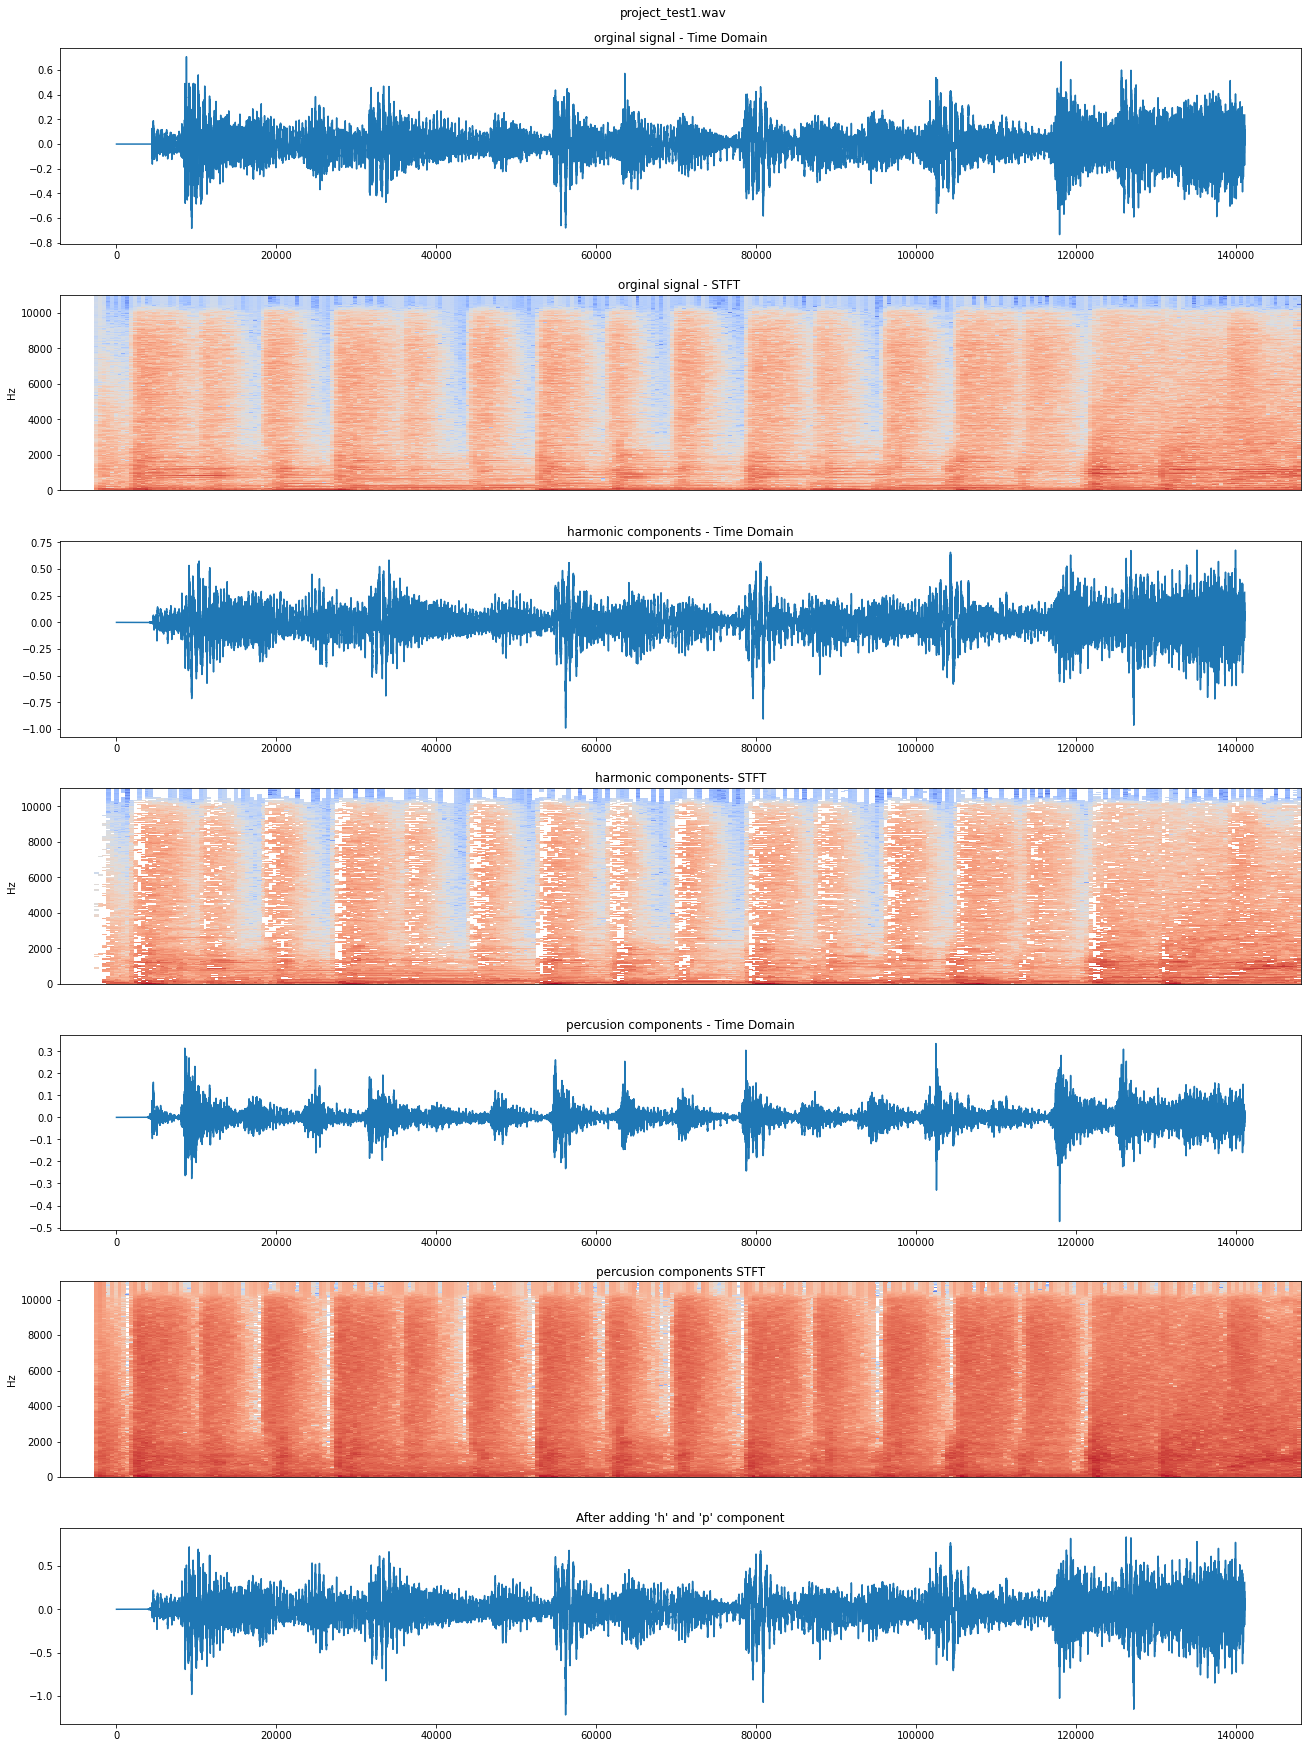

In [156]:
'''
for signal - police03short 
'''

data, Fs = sf.read('police03short.wav')
gamma=0.3
alpha=0.3
#sd.play(data,Fs)
win_length=int(0.02*Fs)
hop_length=int(0.01*Fs)
F=lib_pow_spect(data,win_length,hop_length)
W=np.abs(F)**2
h,p,H,P=sep_percusion_harmony(win_length,hop_length,F,W,Fs,gamma,alpha)


fig,axes=plt.subplots(7,figsize=(25,15))
fig.suptitle("project_test1.wav")
fig.set_size_inches(18.5, 25)
fig.tight_layout(pad=3.0)
axes[0].plot(data)
axes[0].set_title("orginal signal - Time Domain")
dp.specshow(20*np.log10(W), y_axis='linear',ax=axes[1])
axes[1].set_title("orginal signal - STFT ")

axes[2].plot(h)
axes[2].set_title("harmonic components - Time Domain")
dp.specshow(20*np.log10(H), y_axis='linear',ax=axes[3])
axes[3].set_title("harmonic components- STFT")

axes[4].plot(p)
axes[4].set_title("percusion components - Time Domain")
dp.specshow(20*np.log10(P), y_axis='linear',ax=axes[5])#,cmap='gist_earth')
axes[5].set_title("percusion components STFT")

axes[6].plot(h+p)
axes[6].set_title("After adding 'h' and 'p' component")
plt.show()

In [157]:
#percusion of the police03short.wav
sd.play(p,Fs)

In [158]:
#harmonic of the police03short.wav
sd.play(h,Fs)

In [162]:
#SNR of police03short.wav

short_size= data.size if data.size<h.size else h.size
temp_signal=h+p
noise_ratio=20*np.log10(np.sum(np.power(data,2))/np.sum(np.power(data[:short_size]- temp_signal[:short_size],2)))
print("the signal to noise ratio is "+str(noise_ratio))
print("the hyper parameters are ")
print("gamma "+str(gamma))
print("alpha "+str(alpha))
print("the value for the hyper parameters are found through trial and error method")

the signal to noise ratio is 14.410584116926943
the hyper parameters are 
gamma 0.2
alpha 0.3
the value for the hyper parameters are found through trial and error method
